In [1]:
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing
import cv2

DATA_PATH = "./car-damage-data/training/"

def getCV2(path, IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


def save_data_to_array(IMG_SIZE, path=DATA_PATH):
    labels, _, _ = get_labels(path)

    for label in labels:
        cv2_vectors = []
        images = [path + label + '/' + image for image in os.listdir(path + '/' + label)]
        for image in tqdm(images, "Saving vectors of label - '{}'".format(label)):
            cv2V = getCV2(image, IMG_SIZE)
            cv2_vectors.append(cv2V)
        np.save("./npy/" + label + '.npy', cv2_vectors)


def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load("./npy/" + labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load("./npy/" + label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

/home/ashish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = './car-damage-data/training'
TEST_DIR = './car-damage-data/validation'
IMG_SIZE = 50
LR = 1e-3

num_classes = len(os.listdir("./car-damage-data/training"))

In [3]:
os.listdir("./car-damage-data/training")

['01-whole', '00-damage']

In [4]:
save_data_to_array(IMG_SIZE)

Saving vectors of label - '00-damage': 100%|██████████| 920/920 [00:00<00:00, 4056.38it/s]


In [5]:
# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

X = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1)
validate_x = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 1)


Y = to_categorical(y_train)
validate_y = to_categorical(y_test)

In [6]:
X.shape

(1104, 50, 50, 1)

In [7]:
import keras
import matplotlib.pyplot as plt
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import load_model
from keras import regularizers

In [8]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
cnn = get_model()
history = cnn.fit(X, Y, epochs=5, batch_size=50, verbose = 1, validation_data=(validate_x, validate_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

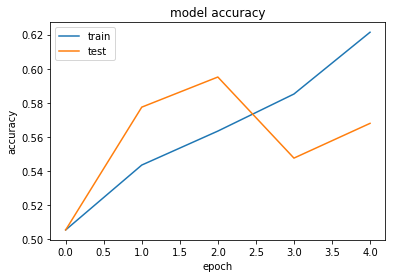

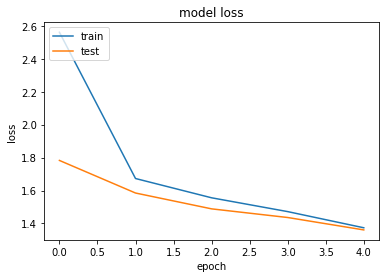

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("acc_epoch20.jpg")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("loss_epoch20.jpg")
plt.show()

In [11]:
cnn.save("car-damage-cnn.h5")

In [13]:
def predict(filename, model):
    path = os.path.join(TEST_DIR, filename)
#     print(path)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = np.array(img)
    data = img.reshape(-1, IMG_SIZE,IMG_SIZE,1)
    res = get_labels()[0][np.argmax(model.predict(data))]
    return res

In [16]:
# print(predict('character_1_ka/46226.png', cnn))

In [15]:
ctr_true = 0
ctr_total = 0
labels = os.listdir(TEST_DIR)
print(labels)
for label in labels:
    images = os.listdir(TEST_DIR + "/" + label)
#     print(images)
    for img in images:
        out = predict(label + "/" + img, cnn)
        if out == label:
            ctr_true += 1
        ctr_total += 1
    
print(ctr_true/ctr_total)

['01-whole', '00-damage']
0.7021739130434783
